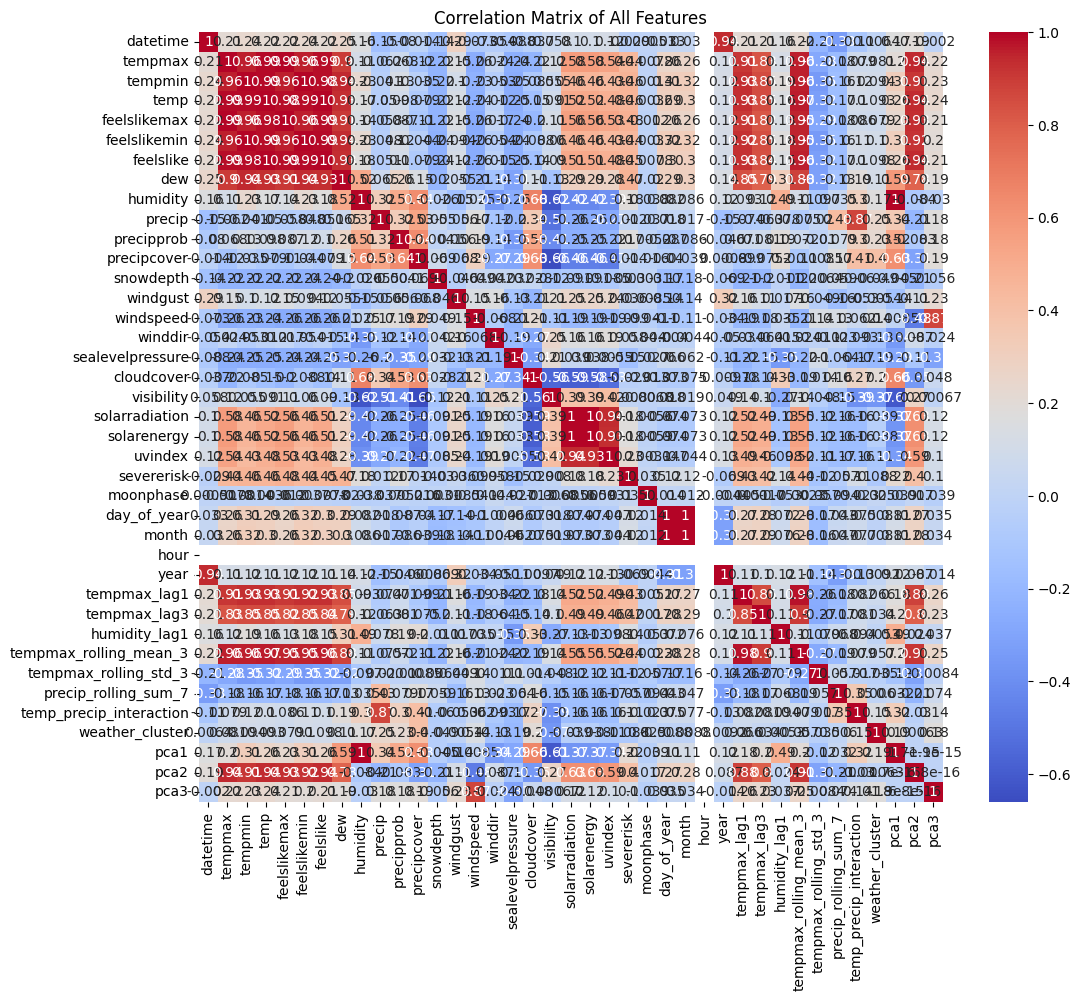


Mutual Information Scores (Top 20):
feelslikemax              3.701258
temp                      1.832232
feelslike                 1.777917
tempmin                   1.252273
feelslikemin              1.247865
tempmax_rolling_mean_3    1.195833
pca2                      1.095411
dew                       0.857276
tempmax_lag1              0.850081
day_of_year               0.843932
month                     0.788653
weather_cluster           0.589953
tempmax_lag3              0.579249
solarradiation            0.348943
solarenergy               0.344807
uvindex                   0.313806
severerisk                0.221892
pca1                      0.123880
tempmax_rolling_std_3     0.123718
cloudcover                0.120791
dtype: float64

XGBoost Feature Importances (Top 20):
feelslikemax              0.952236
temp                      0.033851
pca2                      0.003804
dew                       0.001513
feelslike                 0.001452
tempmax_rolling_mean_3    0.001172

In [4]:
# Filename: data_preprocessing.ipynb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Load the Dataset
file_path = r"../data/NewYork.csv"
data = pd.read_csv(file_path)

# 1. Handle DateTime
data['datetime'] = pd.to_datetime(data['datetime'])
data['day_of_year'] = data['datetime'].apply(lambda x: x.timetuple().tm_yday)
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour
data['year'] = data['datetime'].dt.year

# 2. Drop Unnecessary Columns
columns_to_drop = ['name', 'stations', 'icon', 'description', 'sunrise', 'sunset', 'preciptype', 'snow', 'conditions']
data = data.drop(columns=columns_to_drop)

# 3. Handle Missing Values
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# 4. Feature Engineering
data['tempmax_lag1'] = data['tempmax'].shift(1)
data['tempmax_lag3'] = data['tempmax'].shift(3)
data['humidity_lag1'] = data['humidity'].shift(1)

data['tempmax_rolling_mean_3'] = data['tempmax'].rolling(window=3).mean()
data['tempmax_rolling_std_3'] = data['tempmax'].rolling(window=3).std()
data['precip_rolling_sum_7'] = data['precip'].rolling(window=7).sum()

data = data.fillna(data.mean())

data['temp_precip_interaction'] = data['temp'] * data['precip']

# 5. Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
data['weather_cluster'] = kmeans.fit_predict(data[['temp', 'humidity', 'windspeed', 'precip']])

# 6. Dimensionality Reduction
pca = PCA(n_components=3)
principal_components = pca.fit_transform(data[['temp', 'humidity', 'windspeed', 'precip']])
data['pca1'] = principal_components[:, 0]
data['pca2'] = principal_components[:, 1]
data['pca3'] = principal_components[:, 2]

# Ensure no NaNs remain before mutual_info_regression and other analyses
data = data.dropna()

# 7. Feature Importance and Correlation Analysis
corr_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of All Features')
plt.show()

X = data.drop(columns=['tempmax'])
y = data['tempmax']

X = X.select_dtypes(include=[np.number])
X = X.dropna()

mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print("\nMutual Information Scores (Top 20):")
print(mi_series.head(20))

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgboost_model.fit(X, y)
importance = xgboost_model.feature_importances_
importance_series = pd.Series(importance, index=X.columns).sort_values(ascending=False)

print("\nXGBoost Feature Importances (Top 20):")
print(importance_series.head(20))

# 8. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the processed datasets
X_train_path = r"../preprocessing/X_train.csv"
X_test_path = r"../preprocessing/X_test.csv"
y_train_path = r"../preprocessing/y_train.csv"
y_test_path = r"../preprocessing/y_test.csv"

X_train.to_csv(X_train_path, index=False)
X_test.to_csv(X_test_path, index=False)
y_train.to_csv(y_train_path, index=False)
y_test.to_csv(y_test_path, index=False)

print(f"Training and testing datasets saved to: {X_train_path}, {X_test_path}, {y_train_path}, {y_test_path}")

# 9. Save the Processed and Enhanced Full Dataset
processed_data_path = r"../preprocessing/processed_data.csv"
data.to_csv(processed_data_path, index=False)

print(f"Processed full dataset saved to {processed_data_path}")
